#1. YARN explained

### What is YARN?
* Yet Another Resource negotiator
  - Introduced in hadoop 2
  - Separates the problem of managing resources on your cluster from MapReduce.
  - Enabled development of MapReduce alternatives (Spark, Tez) built on top of YARN.

* It's just there, under the hood, managing the usage of your cluster.
  - You don't really need to write code against YARN these days (Why would you?) But you can.






### Where YARN fits in

At the bottom of Hadoop there is the HDFS, and on top of it there is YARN. YARN is the compute layer for the cluster and it can execute specic jobs or tasks or application chuncs that are depending on processing certain chunks of data that depend on the HDFS cluster.

The idea of YARN is to split the actual computation across the cluster whereas HDFS is splitting up the data storage across your cluster, and these two are pretty tightly integrated (Because YARN tries to mantain data locality, basically if you try to execute a job that is specifically looking to operate on some specific blocks of data in HDFS, YARN will try to align those on the same actual physical host as much as possible). So YARN is basically what's managing the computing resources of your cluster and each HDFS is what's managing the storage resources of your cluster.

On top of YARN there is MapReduce, Spark, Tez, ..., 

Going back to the top hadoop ecosystem we can see that there are alternative resource negotiatiors that can be plugged-in as well.

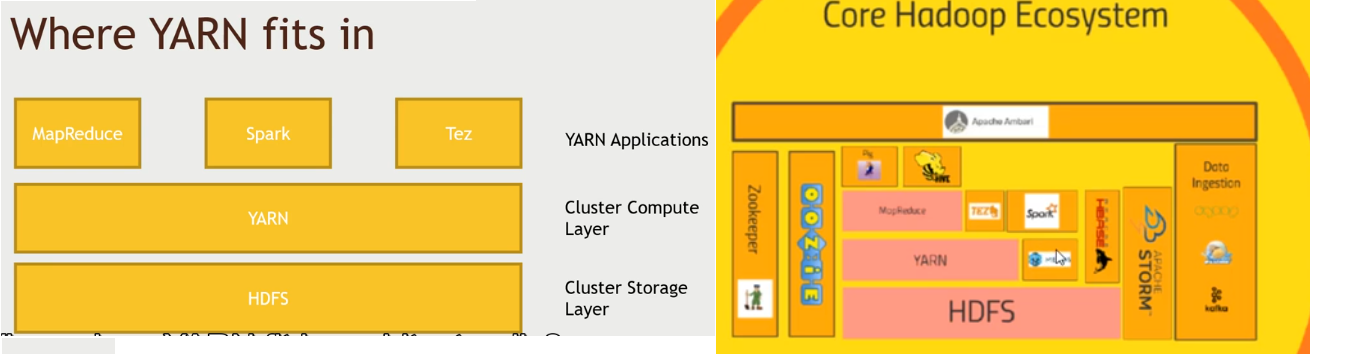

### Remembering how MapReduce works

The image is really just an specific example of how YARN works, so we had the client Node that had the MapReduce script itself that would talk to our HDFS cluster directory in some cases, but that kicks off a request to the YARN resource manager to actually spin up our MapReduce application, and the first thing YARN does is request a NodeManager running on a specific node somewhere that has capacity to do so, and that would be running the MapReduce application master which in turn would ask for more resources through YARN. And these processes (the nodes that are not the application masters), are comunicating to HDFS to get the data that they need.

YARN is basically figures out where to run all of the application processes, where to split up these nodes and how to evenly distribute the processing of that information across the cluster, and do it in such a way that minimized the shuffling of data. So it's both trying to optimize the usage of your cluster from CPU cycles and also trying to mantain data locality (to ensure quick acess to the data)




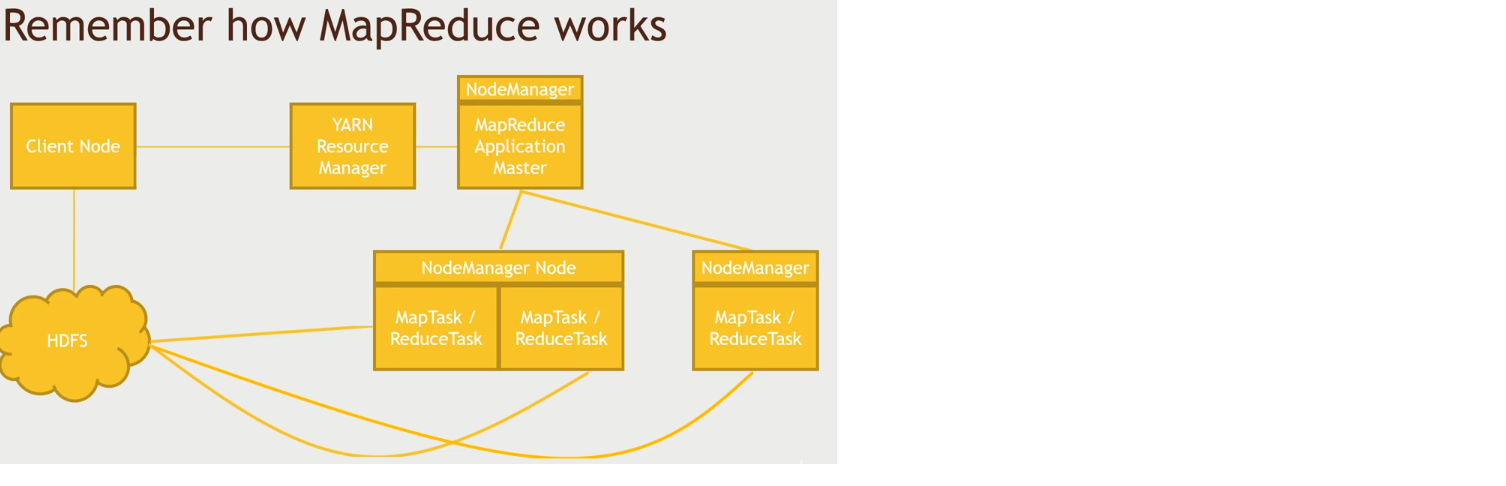

### How YARN works
* Your application talks to the Resource Manager to distribute work to your cluster.

* You can specify data locality - Which HDFS block(s) do you want to process?
  - YARN will try to get your process on the same node that has your HDFS blocks.

* You can specify the different scheduling options for applications.
  - So you can run more than one application at once on your cluster.
  - FIFO, Capacity and Fair schedulers
    + FIFO runs jobs in sequence, first in first out
    + Capacity may run jobs in parallel if there's enough spare capacity
    + Fair may cut into a larger running job if you just want to squeeze in a small one.

### Building new YARN applications

* Why? There are so many existing projects you can just use.
  - Need a DAG (Directed Acyclic Graph), Just build it on Spark or Tez.

* If you really need to:
  - There are frameworks:
    + Apache Slider
    + Apache Twill
  - There are books on the topic 
  



#2. TEZ explained

TEZ it's about accelerating the jobs you run on your cluster.

* It's another big infrastructure you can just use
  - Makes your Hive, Pig, or MapReduce jobs faster!
  - It's an application framework clients can code against as a replacement for MapReduce

* Constructs Directed Acyclic Graphs (DAGs) for more efficient processing of distributed jobs.
  - Relies on a more holistic view of your job; eliminates unnecessary steps and dependencies.

* Optimizes physical data flow and resource usage.

TEZ works with Directed Acyclic Graphs

The image shows a Pig/Hive job that runs on MapReduce, and a Job that runs on Tez. The MR job does everything by steps. While TEZ could just use a more efficient architecture.
(green squres = reducer, blue = mapper)

Remember that Tez sits on top of YARN, and it's on the same level of Spark and MapReduce.

As a user just tell Hive or Pig to use it. NOTE: In the HDP environment it is already default for Hive...


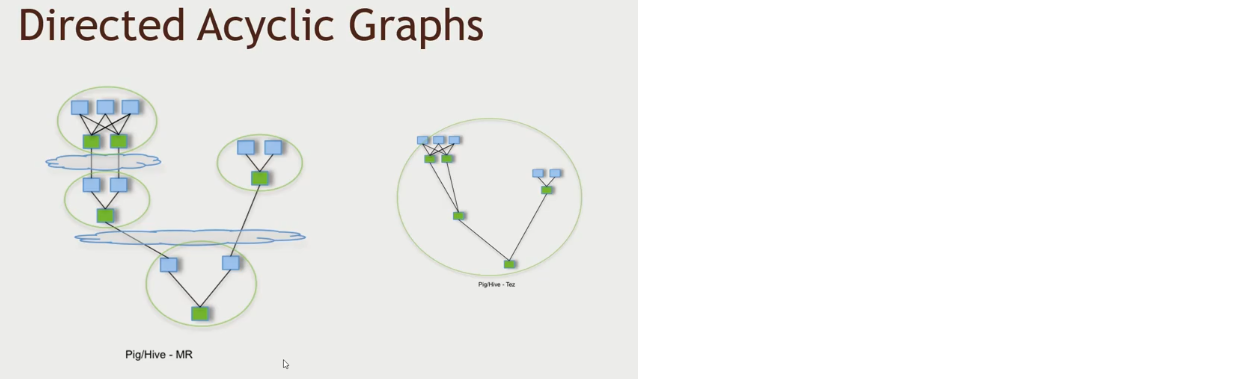

#3. Use Hive on Tez and measure the performance benefit.

1. Fire up HDP and Ambari. -> Hive View. (the movielens data should be there). We also upload the u.item file as a table named 'names'.
2. The query: 
```
DROP VIEW IF EXISTS topMovieIDs;
CREATE VIEW topMovieIDs AS
SELECT movie_id, count(movie_id) as ratingCount
FROM movielens.ratings
GROUP BY movie_id
ORDER BY ratingCount DESC;
SELECT n.name, ratingCount
FROM topMovieIDs t JOIN movielens.names n ON t.movie_id = n.movie_id;
```
So this figures out the topMovieIDs based on how many yimes each movie was rated.
First we remove any table we have previously.
The we create it with the columns movie_id and count(movie_id) as ratingCount (the name of the column), we take the data FROM movielens.ratings. we GROUP BY movie_id and order by ratingCount DESC (which we just created)
We also joined the n.name part of the 'names' table in the database with our created table on the movie_id key

NOTE: To select the engine to run it you click on the gear icon and select where you want the process to run (Hive comes with Tez or MR as default)

NOTE2: if you go to the grid -> you can go to TEZ view and if you click on a job, you can find pretty cool information. You can even find the Graphical view that explains how the process was mapped/reduced.





# 4. Mesos explained

Mesos is another resource negotiatior but it's broader in its scope compared to YARN

### What is Mesos

* Came out of Twitter- it's a system that manages resources across your data center(s).
* Not just for big data stuff 
  - it can allocate resources for web servers, small scripts, whatever (Note: this is not restricted (like YARN) to things coded against YARN like MapReduce or Spark, thigs that need to have data locality to the undestanding, underlying HDFS file system.
  - Mesos can be used to write any application that needs to be distributed among servers.

* Meant to solve a more general problem than YARN - it's really general container management system.

### We are going a bit "off of the reservation"

* Mesos is not technically part of the Hadoop ecosystem per se, but it can play nice with it.
  - Spark and Storm may both run on Mesos instead of YARN.
  - Hadoop YARN may be integrated with Mesos using Myriad
    + So you don't need necessarily to partition your data center between your Hadoop cluster and everything else.

### Differences between Mesos and YARN.

* YARN is a monolithic scheduler . you give it a job, and YARN figues out where to run

* Mesos is a two-tiered system
  - Mesos just makes offers of resources to your application ("framework")
  - Your framework decides whether to accept or reject them
  - You also decide your own shceduling algorithm.

* YARN is optimized for long, analytical jobs like you see in Hadoop. Mesos is built to handle that, as well as long-lived processes (servers) and short-lived processes as well.

### How Mesos fits in
* If you're looking for an architecture you can code all of your organization's cluster application against (Not just hadoop stuff) Mesos can be really useful
  - You should alo look at Kubernentes / Docker.

* If all you are about is Spark and Storm for the Haddop-y world, Mesos is an option
  - But YARN is probably better, specially if you data is on HDFS
  - Spark on Mesos is limited to one executor per slave (node)

### Siloed vs rosource sharing
There are options to run YARN and Mesos togheter, (Siloed: You can just say: This computers/Nodes work with mesos and work for XXX Process) Or you can tie them togheter (For best use of computer resources)

### When to use Mesos.
* If your organization is already using Mesos.
  - You can avoid partitioning off a hadoop cluster by using Myriad.
  - There is also a "Haddoop on Mesos" package for Cloudera that bypasses YARN entirely.

* If you'r organization is not using Mesos already. You just probably not use Mesos.




 

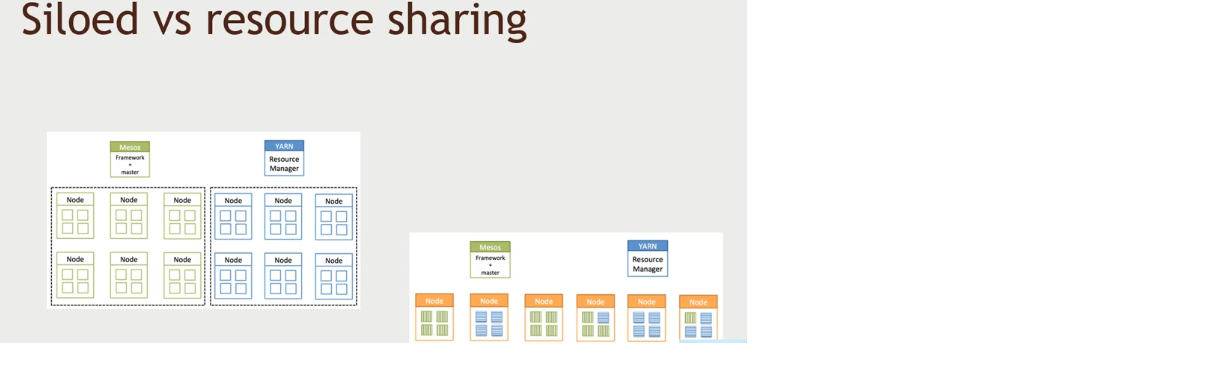

# 5. Zookeeper explained

It's an important system for mantaining data across your cluster.

* It basically an external tools that keeps track of information that must be synchronized across your cluster and that can be used across applications like HBase to restore failures.
  - Which node is the master?
  - Which tasks are assigned to which workers?
  - Which workers are currently availiable

* It's a tool that applications can use to recover from partial failures in your cluster.

* An integral part of HBase, High-Availability(HA) MapReduce, Drill, Storm, Solr, and more.

### Failure Modes zookeepers helps with.

* Master crashes, needs to fail over to a backup.
  - In a high availiability system just has other masters running as a backup, and all the clients talking to the system need to agree on who to talk as a master (That's what zookeper does)

* Worker crashes - its work needs to be redistributed.
  - Zookeeper notifies the application to distribute the work accordingly.

* Network trouble - part of your cluster can't see the rest of it.
  - For some reason two datacenters can no longer talk to each other, Zookeeper notifies the application.

### "Primitive" operations in a distributed system

* Master election
  - One node registers itself as a master, and holds a "lock" on that data
  - Other nodes cannot become master until that lock is released.
  - Only one node allowed to hold the lock at a time.

* Crash detection
  - "Ephemeral" data on a node's availiability automatically goes away if the node disconnects, or fails to refresh itself after some time-out period.

* Group management

* Metadata
  - List of outstanding tasks, task assignments.

### Zookeeper's API is not about these primitives.
* Instead they built a more general purpose system that makes it easy for applications to implement them
  - Basically zookeper does not solve those problems, zookeper just provides tools (like the notifications) to other applications to solve them

### Zookeeper's API
* Really a really consistent little distributed file system.
  - With strong consistency guarantees
  - Replace the concept of "file" with "znode" and you've pretty much got it.

* Here's the zookeeper API:
  - Create, delete, exists, setData, getChildren.

Think of it like the following image, it is a little file system that lives on a tiny distributed cluster of its own and we might have a router or a file system under the forward slash (/) route and maybe there's a /master file that contains some data (The data that tells the rest of your cluster who the current master is) and if that went down, zookeeper automatically replaces the data. There could also be worker nodes that have a list of availiable workers.

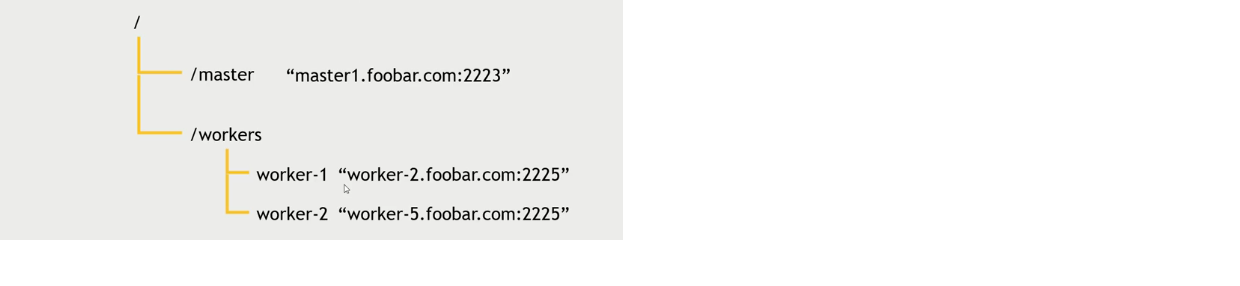

### Notifications
* A client can register for notifications on a znode (basically you get a text or custom message when something happens)
  - Avoids continous polling
  - Example: register for notification on / master - if it goes away, try to take over as the new master.

### Persistent and ephemeral znodes
* Persistent znodes remain stores until explicitly deleted
  - i.e assignment of tasks to workers must persist even if master crashes
  - This is useful because if the master goes down you still want that information of the outstanding work that needs to be done to live on. So that when the new master picks up, it knows where to pick up from where the previous master left off.

* Ephemeral znodes go away if the client that created it crashes or loses its connection to ZooKeeper.
  - i.e if the master crashes it should release its lock on the znode that indicates which node its the master.

### Zookeeper architecture

Zookeeper has the application on the side (left) with zookeper linked to it, and they will talk to a Zookeper enesemble (a group of zookeper servers, if you only have one, and that crashes that is a point of failure).

Your zookeeper clients have a list of the servers it can connect to, and the ensemble is responsible of replicating data in and off itself. If any worker says: "I want to write something to a Znode" it waits until some specified replication factor comes back (depending on the consistency you want, how many servers do we need to agree?)

In Zookeeper (like mongo) you want to have at least 3 servers to get proper consistency. Also note: if you set a "consistency level" of two (two servers need to agree). But what if two servers stop communicating with the rest, if you had a level of two, and the application talks to those two servers, you will still get the confirmation, but the data will not be properly replicated. (and you will get different answers depending on which server the client is speaking to, and thats real bad). This is a "split brain" scenario. The solution here would be to have a "quorum"(consistency level) of 3 and in every physical location, (if you had 2 servers somewhere and 3 somewhere else by having quorum of 3, you make sure that in every location there is at least one server that has to confirm). You want to have at least 5 servers with a quorum of 3.

This is the CAP theorem, Zookeeper   


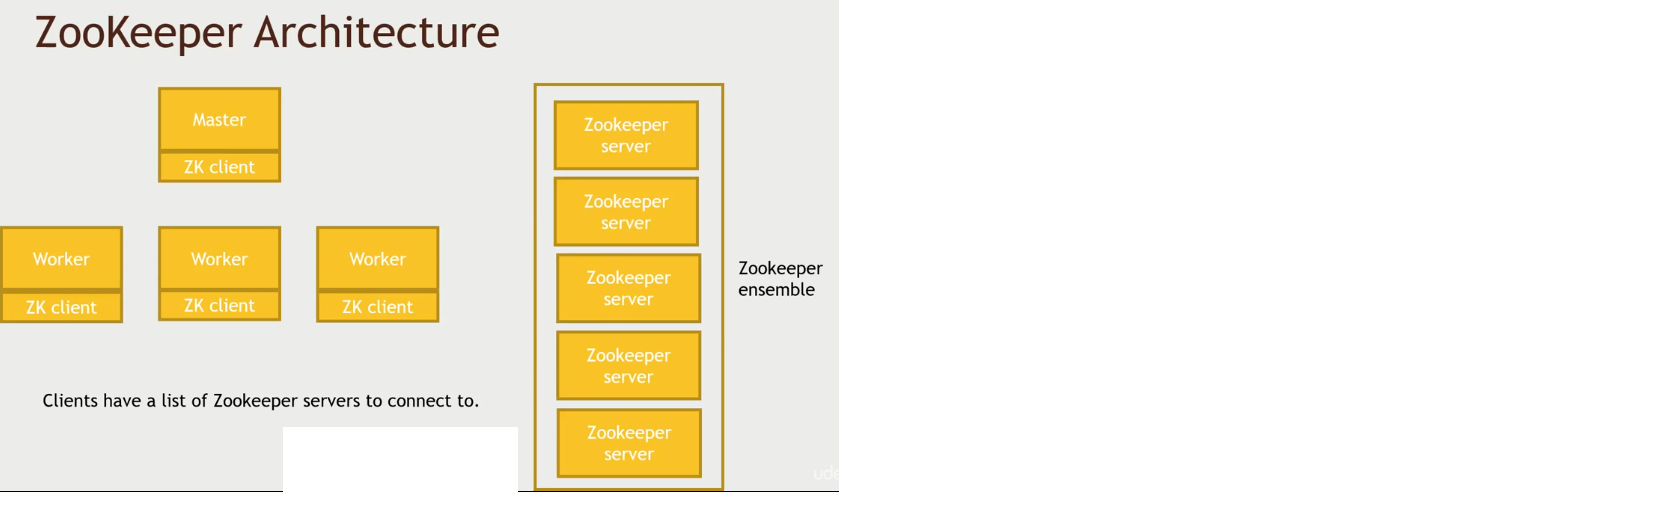

# 6. Simulating a failing master with ZooKeeper

Zookeeper is alreadt installed with HDP

1. in PuTTY `cd /usr/hdp/current/zookeeper-client` -> `./zkcli.sh` and we are connected to zookeeper. Zookeeper just looks like a little file system, the secret is that it is highly consistent and self-replicating.

Now lets pretend we are setting up a new system and we have a system with a single master and my application is once is running on a node that wants to become the master of the system
`create -e /testmaster "someText"` <- This creates an ephimeral ZNode. As soon as this node goes away, that node will also go away.

Now we can say `get \testmaster` and returns the result. And any client in the system would get this.

If the node goes away we can say `quit`, and now the \testmaster node is dead, (because it was ephimeral and automatically deleted.)

So if we imagine we are another user wants to see the master, and tries to connect to /testmaster, but it does not exist, so the application might say "Well if I dont have a master, maybe I should be the master, and It will nominate itself as the master" 

Now if we want to create another node called /testmaster zookeeper wont allow it.

NOTE: In real life you would use Java or C++ to actually run this.

#7. OOzie explained
Oozie orchestrates your hadoop jobs and it's a bit more hands on, and you can actually interact with it and configure it if you actually want to run your Hadoop jobs in production and change things togheter in ways that they depend on each other.

### What is Oozie
* Burmese for "elephant keeper"
* A system for running and shceduling Hadoop tasks.

### Workflows

Workflows allow you to tie togheter differnt actions within Hadoop.
* A multi-sate Hadoop job
  - Might chain togheter MapReduce, Hive, Pig, Sqoop and distcp tasks.
  - Other systems available via add-ons (like spark)

* A workflow is a Directed Acyclyc Graph of actions.
  - Specified via XML
  - So, you can run actions that don't depend on each other in parallel.

Every Workflow has a star-node and end node, it also has forkNodes that indicate actions that have to be done at the same time. The nodes can do many things, A Join node waits untill all nodes before finish and joins the data.

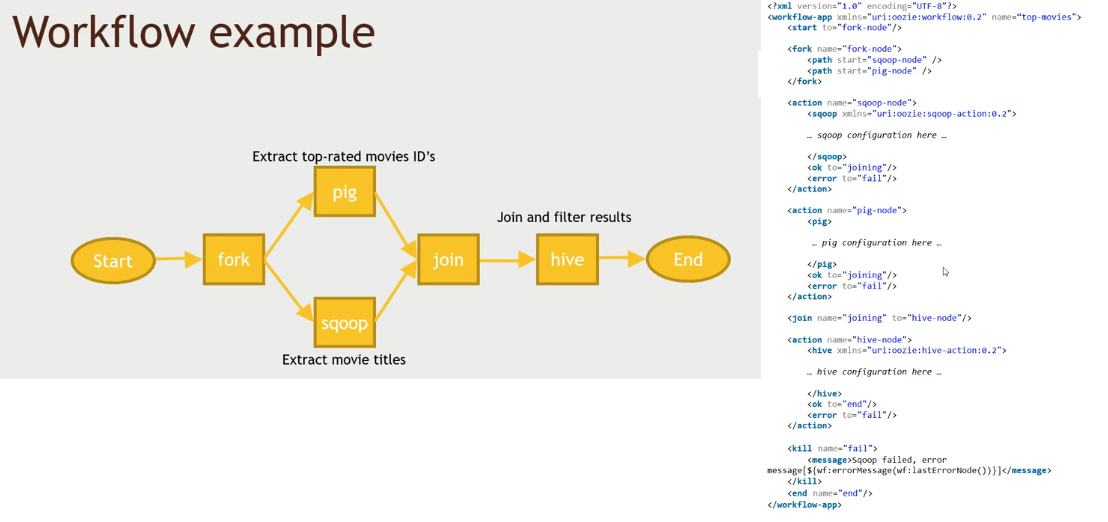

The workflow is specified in XML, code example shown in image. Some explanation.

1. First you specify the `<start` node.
  - which just says go `to= fork-node` and it directs the workflow to the fork named 'fork-node'

2. This 'fork-node' has now two paths, 'sqoop-node' and 'pig-node'.
  - It now goes to these nodes and kicks up their process simultaneously.

3. The nodes where the fork directed: 'sqoop-node', 'pig-node'
  - This nodes just start the action you specify. (Just specify the file/script) you want to run
  - after they finish `<ok=` se dirigen al siguiente nodo, en este caso es el join node llamado `joining`
  - NOTE: There is an error condition that laeads to a message and an error node.

4. El 'joining' node.... tiene configurado como `<join` en el XML, es posible que solo pegue todo junto y lo manda al `hive-node`. 
  - NOTA: También es posible que no transfrome los datos realmente y que uses hive para eso?
  - NOTA: Como se ven las tablas? se ven como archivos en HDFS?. Cuales son sus nombres?

5. Pasa al 'hive-node' donde hace más acciones y luego termina en el end-node

### Steps to set up a workflow in Oozie:

* Make sure each action works on its own
  - Debugging whithin Oozie is not easy, just make sure everything works before sending to Oozie
* Make a directory in HDFS for your job (Here will the configuration be saved).
  * Create your own workflow.xml file and put it in your HDFS folder.
  * Create job.properties defining any variables your workflow.xml needs. (This way the file would work on different servers and locations)
    - This goes on your local filesystem where you'll launch the job from.
    - You could also set these properties within your XML. (Example of some properties)
      * `nameNode = hdfs://sandbox.hortonworks.com:8020`
      * `jobTracker = http://sandbox.hortonworks.com:8050`
      * `queueName = default`
      * `oozie.use.system.libpath = true`
      * `oozie.wf.application.path = ${nameNode}/user/maria_dev`

### To actually run a workflow with Oozie:

* In your masternode of the cluster `oozie job --oozie http://localhost:11000/oozie-config/home/maria_dev/job.properties-run` 
  + The parameters are where you want to run the Oozie console and -config to wherever the job.properties file is that you want to set up your job from.
* Monitor progress at http://127.0.0.1:11000/oozie
  - That adress is the Oozie console, (You can only see things here, not actually edit them)

### Oozie Coordinators
The concept of coordinators is basically that what you really want to do is schedule the execution of the workflow in some periodic bases. (kick off at 7 A.M and run every 12 hours)

* Schedules workflow execution
* Launches workflows based on a given start time and frequency
* Will also wait for required input data to become available
* Run in exactly the same way as a workflow. (But the XML app looks different)




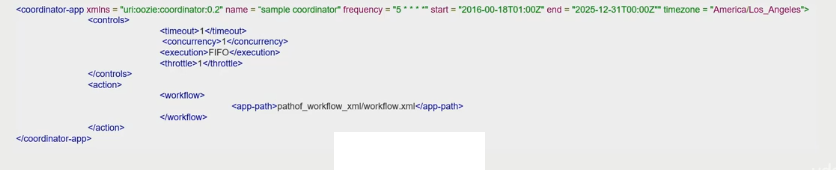

### Oozie bundles

* A bundle is a collection of coordinators that can all be managed togheter.

* Example: you may have a bunch of coordinators for processing log data in various ways.
  - By grouping them in a bundle, you could suspend them all if there were some problem with a log collection. (Which is not really that uncommon), and if needed you can pause everything by just turning off the bundle.

NOTE: Creating and managing bundles turns out it's really complex and we will not cover that

### Exercise, set up a simple workflow in Oozie.

* We'll get movielens back into MySQL if it's not still there.
* Write a Hive script to find all movies released before 1940.
* Set up an Ozzie workflow that uses sqoop to extract movie information from MySQL, then analyze it with Hive.

#8. Set up a simple Oozie workflow

1. Kick off hortonworks HDP virtual environment and PuTTY
2. To check is we have data `mysql -u root -p` -> `show databases` -> this here we need to upload the data to MySQL -> `wget http://media......./movielens.sql` Basically a SQL script that willl populate a movielens table in MySQL. -> We also need to set names to plain english because some titles are foreing `set names 'utf8'` and `set character set utf8;` -> Now we create the database `create database movielens;` -> `use movielens;` -> ´source movielens.sql;´ to execute the script to populate the database. And the data is there.

3. We need to set up permissions so that SQOOP can access it. `grant all privileges on movielens. * to ''@'localhost';` (NOTE: this is all in the `mysql>` "console") -> Now we quit MySQL `quit`

4. Now we get the hive script: ´wget http://media.sundog-soft.com/hadoop/oldmovies.sql´, which gives the following code:
```
DROP TABLE movies;
CREATE EXTERNAL TABLE movies (movie_id INT, title STRING, release DATE) ROW FORMAT DELIMITED FIELDS TERMINATED BY ',' LOCATION '/user/maria_dev/movies/';
INSERT OVERWRITE DIRECTORY '${OUTPUT}' SELECT * FROM movies WHERE release < '1940-01-01' ORDER BY release;
```
  * What it does is that it `DROP`s any existing movie table that might exist in Hive.
  * it `CREATE`s an external table called movies with the columns `movie_id INT, title STRING, release DATE` and the row format is delimited by ´','´ and we show it the `LOCATION` 
  * the `INSERT OVERWRITE DIRECTORY` format overwrites the existing data in the directory with the new values using Hive, Then it filters the movies where the release date is older than 1940.

In the end what we are trying to do is to create a Hive table based on what just got dumped into the user maria_dev movies directory and that's going to be populated by sqoop just pulling data right out of MySQL and into that directory. So after SQOOP extracts the movie data from MySQL, this Hive script will just create a movies table based on that extract (And tells the specifics of the columns) -> then we create the directory that is passed as a parameter called output (`INSERT OVERWRITE DIRECTORY '${OUTPUT}'` and that will be set up through our properties file for the Oozie job. -> And what we output into the `OUTPUT` directory are the results of the query filter (< 1940) 



### Lets get OOzie set up itself

1. Get the workflow file `wget http://media.sundog-soft.com/hadoop/workflow.xml`
  * So we have the XML header and it says we will include a workflow application (workflow app = 'old movies').
  * It starts with a node named sqoop-node. -> which leads to an action named "sqoop-node"
  * It has a tracker and a namenode
  * It deletes any previous instances of the movies folder. (In `<prepare>`)
  * We set a `<configuration>` where we tell it some properties and environment variables.
  * The `<command>` actually tells sqoop what to run. This one connects to MySQL and extract the movies table with a single mapper.
  * If it succeeds it goes to `hive-node` else it goes to error node.
  * Now in the HIVE-NODE (It has the same start code (properties, config, prepare...)
  * The `<script>` tells it which script will it run. 
  * Now in the `<param> it just rell it where the output is going to go` This is because the `${OUTPUT}` in the hive 'oldmovies.sql' script, this param is what tell it what the output is.


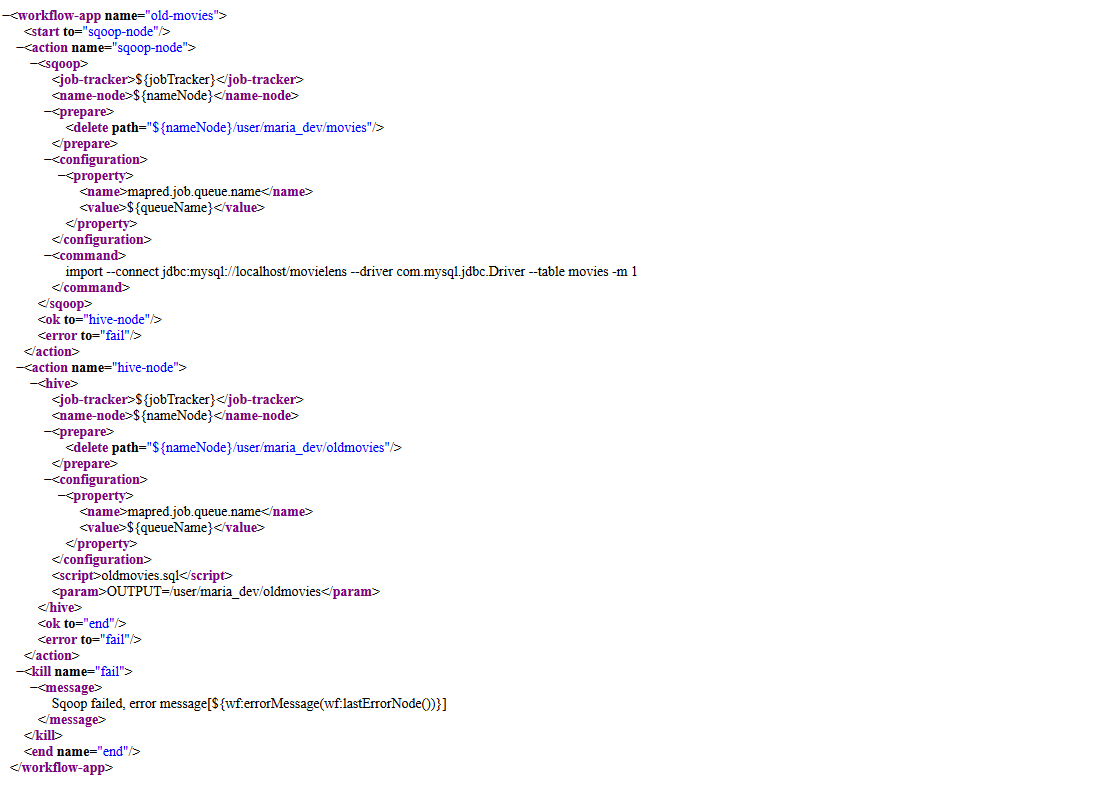

We also need our properties file to actually run the job with

1. `wget http://media.sundog-soft.com/hadoop/job.properties` 
  * This contains all the variables we see in the workflow.xml file
```
nameNode=hdfs://sandbox.hortonworks.com:8020
jobTracker=http://sandbox.hortonworks.com:8050
queueName=default 
oozie.use.system.libpath=true
oozie.wf.application.path=${nameNode}/user/maria_dev
```
  * the actual URL including port numbers, for YARN and resource manager
  * We say we use the system library path, and we get the actual workflow of the workflow.xml file
  * NOTE: In real world this should be better organized, where individual jobs look into individual subdirectories (You probably would not be running in maria_dev, you would be running in some kind of oozie account, etc...)

2. We need to upload the workflow.xml file into hdfs so that OOzie can actually use it. To do that we say: `hadoop fs -put workflow.xml /user/maria_dev`
3. We also need to put our hive script where it expects it to be, so we say `hadoop fs -put oldmovies.sql /user/maria_dev`
  * NOTE: This is all in PuTTY prompt.

4. In order for SQOOP to connect to my-sql we need to install a connector. `hadoop fs -put /usr/share/share/java/mysql-connector-java.jar user/oozie/share/lib/lib_20161025075203/sqoop` Note: the first part is the command and the second is where to put it. Note2: how to make sure we have the right number
  * Go to Ambari dashboard
  * files view (in grid)
  * user -> oozie -> share -> lib -> and there is the number.

5. Now we need to restart oozie -> go to Ambari -> services tab -> oozie -> Service Actions -> restart all.

We can now kick off our oozie workflow.
1. in PuTTY `oozie job -oozie http://localhost:11000/oozie -config /home/maria_dev/job.properties -run` so we tell it the oozie port, the location of our properties (in hdfs?) and run it.
  * This gives us back a job_id and if we go to our brower: `127.0.0.1:11000/oozie` and here we can see the job is running.
  * We can click on the job and see the Job DAG (graph) and we can do other simple things. There is not really anything to edit, it's pretty much just visualizing.



To see the actual output
1. Go to Ambari -> files view -> user/maria_dev/oldmovies -> (we click the file in oldmovies folder) and it gives us the data.

# 9. Zeppelin overview
Zeppelin is primarly used as a quick way to experiment with your Spark script and visualize your big data and slice it in different ways, it also has plugins for other components like Cassandra, HDFS, Pig, etc...

Zeppelin sits on top of the broader spectrum of technologies on your stack.

Zeppelin is understood better when you actually use it. It makes it easy to experiment and visualize your data interactievely.


### What is Zeppelin
it's a notebook interface for your big data.

* If you're familiar with iPython notebooks -it's like that
  + It lets you interactively run scripts / code against your data
  + Can interleave with nicely formatted notes.
  + Can share notebooks with others on your cluster.

* If you're not familiar with iPython notebooks -well, you kind of just have to see it.

We can put information in some organized way, we can also share the notebooks with other people and collaborate more easily.

### Apache spark integration.
Zeppelin has very thight integration with Apache Spark.

* Can run Spark code interactively (like you can in the Spark shell)
  + This speeds up your development cycle
  + And allows easy experimentation and exploration of your big data

* Can execute SQL queries directly against SparkSQL

* Query results may be visualized in charts and graphs.

* Makes Spark feel more like a data science tool.

It makes Hadoop feel more like a data science tool.

NOTE: Zeppelin can do much more than just Spark, it has a lot of interpreters for lot's of programs like Cassandra, Google BigQuery, HBase, etc... (There are a lot)

Note: Zeppelin comes pre-installed in HDP


# 10 and 11. Use Zeppelin to analyze movie ratings. 

with HDP open you go to 127.0.0.1:9995

To create a new notebook simply press the create new note button. and give it a name.

To make sure things are set up properly:
  * First we need to tell it how to prioritize the interpreters it has (we don't want it thinking Spark code is Pig code, etc...).
    * To do that you click on the gear icon (settings) and drag and drop things in the order you want. (In this case spark should be on top)

* Note: `%md` at the beginning of the block means that the block of code will be markdown.  And you can write text.

* `sc.version` and we can check the version of spark.
* `%sh` means we will execute a shell command in that block
  * Then you skip a line in the block and write your command. `wget http://media.sundog-soft.com/hadoop/ml-100k/u.data -O /tmp/u.data` Basically is like we were using PuTTY, we the command tell it to get that data and put it in the /tmp/ folder as 'u.data'
  * In the next line (not block) we write `wget http:media.sundog-soft.com/hadoop/ml-100k/u.item -O /tmp/u.item`
  * We can do `echo "Downloaded!"` like a print statement.
  * We execute the block






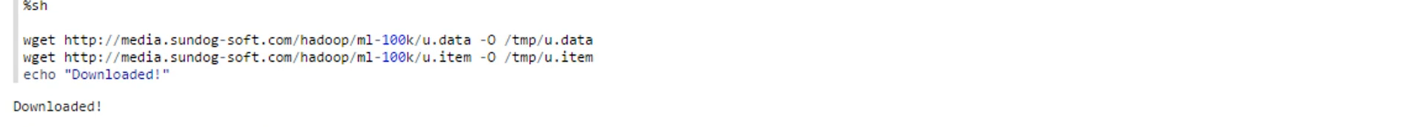

Now, this copies the data to the local file system, we want it in HDFS, to do that:
```
%sh
hadoop fs -rm -r -f /tmp/ml-100k #Remove data if its there.
hadoop fs -mkdir/tmp/ml-100k # create the dir in hadoop
#basically tell it where is the data and where it should go.
hadoop fs -put /tmp/u.data /tmp/ml-100k/
hadoop fs -put /tmp/u.item /tmp/ml-100k
```

We will write some SCALA code to analyze our data. We will load the ratings into a Spark dataframe.
```
# In SCALA we need case class.
# The code says we create a class object called rating that consists of two data members, 
# one is an integer based movieID and one is an iteger based rating.
# This allows us to create a Spark Dataframe from our raw data.

final case class Rating(movieID: Int, rating: Int)

# We load up the data:
val lines = sc.textFile("hdfs:///tmp/ml-100k/u.data").map(
  x => {val fields = x.split("\t"); Rating(fields(1).toInt, fields(2).toInt)})

# Now that basically extracts every field that is tab delimited
# into a variable called fields using the split command (by tab)
# Then we return a Rating object that starts counting from zero in scala.
```

Now we have an RDD in Spark lines, but we want a DataFrame because I want to issue SparkSQL commands against it.

In another block:
```
import sqlContect.implicits._
val ratingsDF = lines.toDF() # converts ratings to a DF
# Note that we used the lines variable we created before to process the data.

ratingsDF.printSchema() # to check the dataFrame we just created
```

Now if we want to figure the top movie ID's
```
val topMovieIDs = ratingsDF.groupBy movieID.count().orderBy(desc("count")).cache()
#So we aggregate togheter all the ratings by movie ID and count them up.
# and we sort it in descending order and we cache it.
```









NOTE: WE ARE WORKING IN SPARK 1.6 NOT 2, SO SOME SPARK CODE MIGHT CHANGE.

Now we want to load also the movie names information to get the movie titles and merge that with the data we got (only movie_id).

```
ratingsDF.registerTempTable("ratings") # We will take the ratings dataframe and 
# create a table in SparkSQL called ratings.
```
The new code block means another block in the notebook.
```
%sql

SELECT * FROM ratings LIMIT 10
```
Our spark dataframe is now behaving like a SQL database... cool

```
%sql
SELECT rating, COUNT(*) as count FROM ratings GROUP BY rating
# Basically this creates a count of all the rating type (1,3, stars...)
# It literally returns a list of 5 with rating and the count.
```
Zeppelin allows you to create a histogram just by clicking a button in the notebook. We can also make line chart, scatter plot, pie chart, etc... And there are plugins for other stuff.

```
final case class(movieID: Int, title: String)

val lines = sc.rextFile("hdfs:///tmp/ml-100k/u.item").map(x => {val fields = x.split('|'); Movie(fields(0).toInt,fields(1))})

# Basically this tell it that each line in the data will be split by '|'
# And it will return a movie object that consists of the first and second
# fields of that raw data file.

import sqlContext.implicits._
val moviesDF = lines.toDF()
```

Now we have the data with the Ids and the name

```
moviesDF.registerTempTable("titles")
# now we have our tables in our movieDF Dataframe.
```
now we merge the tables to see the names and ID

```
%sql #remember this is SparkSQL not just SQL

SELECT t.title, count(*) FROM ratings r JOIN titles t ON r.movieID = t.movieID GROUP BY t.title, ORDER BY cnt DESC LIMIT 20

# Basically we get the most rated movies in our database and we're 
# joining in the movie title information so we can actually see 
# what those movies really are.
```

NOTE; you can download the notebook from:

http://media.sundog-soft.com/hadoop/MovieLens.json












# 12. HUE overview

Hue is not availiable in HDP but it is in cloudera. (And you use it a lot)

HUE: HADOOP USER EXPERIENCE

Basically Cloudera and Apache compete for the distribution of Hadoop, they are similar, but different. (Cloudera is #1)

### A tale of two Distros
* Hortonworks
  - Ambari used for management and query / files UI
  - Zeppelin used for notebook

* Cloudera
  - Hue used for query / files UI and notebook
  - Cloudera Manager used for management

* Hue is Cloudera's Ambari - Sortof

The main difference is that Hortonworks is 100% open-source

### Cool things about HUE:
* It has a proper OOzie editor (graphical editor)
  - Also Spark, Pig, Hive, HBase, HDFS, Sqoop.

* Built-in notebooks

### There is a live demo of hue in gethue.com

And in play with a live demo.